# SAMap zebrafish Farrell 10 - 12 hpf vs amphioxus N5results
With leiden-based neighborhoods

Zebrafish proteins

In [1]:
from samap.mapping import SAMAP
from samap.analysis import (get_mapping_scores, GenePairFinder, sankey_plot, chord_plot, CellTypeTriangles, 
                            ParalogSubstitutions, FunctionalEnrichment,
                            convert_eggnog_to_homologs, GeneTriangles)
from samalg import SAM
import pandas as pd
import numpy
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scanpy as sc
import warnings
warnings.filterwarnings(action='ignore')
import pickle
import anndata as ad
import holoviews as hv
from bokeh.io import export_svg

def export_svg2(obj, filename):
    plot_state = hv.renderer('bokeh').get_plot(obj).state
    plot_state.output_backend = 'svg'
    export_svg(plot_state, filename=filename)

with open('sam_processed.pkl', 'rb') as inp:
    sm = pickle.load(inp)

### Add coarse annotation

In [2]:
with open('../../input_data/farell_coarse_annot_map.csv') as f:
    annot_map=[tuple(line) for line in csv.reader(f)]

annot_map=dict(annot_map)

sm.sams['dr'].adata.obs['celltype_coarse']=sm.sams['dr'].adata.obs['segment_celltype'].replace(annot_map).astype(str)

sm.sams['dr'].adata.obs['celltype_coarse_stage']=sm.sams['dr'].adata.obs['celltype_coarse'].astype(str)+'_'+sm.sams['dr'].adata.obs['stage_fine'].astype(str)
sm.sams['bf'].adata.obs['celltype_coarse2_stage']=sm.sams['bf'].adata.obs['celltype_coarse2'].astype(str)+'_'+sm.sams['bf'].adata.obs['stage'].astype(str)


concat_ads=ad.concat({'Zebrafish':sm.sams['dr'].adata,
                     'Amphioxus':sm.sams['bf'].adata}, label="dataset")

# Post-SAMap analysis

## Visualizing the combined projection

In [ ]:
sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=False,
                title='SAMap UMAP amphioxus N5 vs Zebrafish 10-12 hpf',
                palette={'Zebrafish':('#1b9e77',0.8),'Amphioxus':('#d95f02',0.8)})

Visualise both objects with celltypes

In [ ]:
vis_keys_bf=['stage','celltype_coarse2']
vis_keys_dr=['stage','celltype_coarse']
print('Amphioxus integrated')

sc.pl.embedding(sm.sams['bf'].adata,
                    basis='X_umap_samap',
                    color=vis_keys_bf,
                    frameon=False,save='_amp_int_celltypes.pdf')

print('Zebrafish integrated')
sc.pl.embedding(sm.sams['dr'].adata,
                    basis='X_umap_samap',
                    color=vis_keys_dr,
                    frameon=False,save='_dr_int_celltypes.pdf')

## Selected celltype visualisation

In [ ]:
ncols = 3
nrows = 1
figsize =6.5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

sc.pl.embedding(sm.sams['bf'].adata,
                    basis='X_umap_samap',
                    color='celltype_fine',
                    groups=['PrechordalPlate','Notochord','MNCC-likeCells','PMNCC'],
                    frameon=True,
                   title='Amphioxus N5',ax=axs[0], show=False)
#sm.scatter(COLORS={'dr':'#10b9f1','bf':'#f14810'},axes=axs[1],ss={'bf':5,'dr':5},alpha=0.5)

sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=True,
                title='Combined by SAMap',
                palette={'Zebrafish':('#1b9e77',0.8),'Amphioxus':('#d95f02',0.8)},ax=axs[1],show=False)

sc.pl.embedding(sm.sams['dr'].adata,
                    basis='X_umap_samap',
                    color='segment_celltype',
                    groups=['29_Lineage_Prechordal_Plate',
                            '32_Lineage_Notochord',
                            '59_Lineage_Midbrain_Neural_Crest',
                            '59_Lineage_Placode_Olfactory',
                            '61_unassigned',
                           '70_unassigned'],
                    frameon=True,
               title='Zebrafish 10-12 hpf', ax=axs[2])
#fig.savefig('figures/comparison_selection.pdf',bbox_inches='tight')
#fig.savefig('figures/comparison_selection.png',bbox_inches='tight',dpi=300)

### Visualise prechordal plate markers

In [ ]:
zebra_pp_markers=['dr_six3b','dr_six7','dr_gsc','dr_foxa3','dr_otx1a']
amp_pp_markers=['bf_Six3/6','bf_Six4/5','bf_Cerberus','bf_Dmbx','bf_Fz5/8']
print('Amphioxus PP markers')
with rc_context({"figure.figsize": (4, 6)}):
    sc.pl.embedding(sm.sams['bf'].adata,
                    basis='X_umap_samap',
                    color=amp_pp_markers,
                    frameon=False,
                    colorbar_loc=None,
                    ncols=5)
    print('Zebrafish PP markers')
    sc.pl.embedding(sm.sams['dr'].adata,
                    basis='X_umap_samap',
                    color=zebra_pp_markers,
                    frameon=False,
                    colorbar_loc=None,
                    ncols=5)

### Notochord markers

In [ ]:
zebra_noto_markers=['dr_noto','dr_mnx1','dr_foxd5','dr_foxa2','dr_chd']
amp_noto_markers=['bf_Admp','bf_Mnx','bf_Goosecoid','bf_Shh','bf_Chordin']
print('Amphioxus Noto markers')
with rc_context({"figure.figsize": (4, 6)}):
    sc.pl.embedding(sm.sams['bf'].adata,
                    basis='X_umap_samap',
                    color=amp_noto_markers,
                    frameon=False,
                    colorbar_loc=None,
                    ncols=5)
    print('Zebrafish Noto markers')
    sc.pl.embedding(sm.sams['dr'].adata,
                    basis='X_umap_samap',
                    color=zebra_noto_markers,
                    frameon=False,
                    colorbar_loc=None,
                    ncols=5)

## Calculating cell type mapping scores

To calculate alignment scores between cell types, we can use `get_mapping_scores`. This function will use the combined SAM object produced by SAMap to calculate alignment scores between cell types in the provided cell type annotation columns of `sam.adata.obs`. If no cell type annotations exist, the leiden clusters generated by SAM can be used (`'leiden_clusters'`).

The resulting tables show the highest-scoring alignment scores for each cell type (`D`) and pairwise mapping scores between cell types (`MappingTable`).

The `n_top` parameter can be used to identify strongly-mapping subpopulations between clusters. If `n_top=0`, the alignment score will be averaged over all cells between two clusters. Otherwise, the alignment score will be averaged over the top `n_top` cells.

For example, let's say there are 100 / 1000 cells in Cluster A that maps to a Cluster B in the other species. On average, the mapping score between cluster A and B will be small, because there are only a few cells in cluster A that map to cluster B. If we set `n_top` to 100, then the alignment score between A and B will be averaged over the 100 highest-scoring cells. As a result, the mapping score between A and B will be large.

By default, `n_top=0`.

In [3]:
D,MappingTable = get_mapping_scores(sm,{'dr' : 'stage', 'bf' : 'stage'},n_top = 0)
D50_fine,MappingTable50_fine = get_mapping_scores(sm,{'dr' : 'segment_celltype', 'bf' : 'celltype_fine'},n_top = 50)
MappingTable50_fine.filter(regex=("bf_.*")).filter(axis='index',regex=("dr_.*")).to_csv('Mapping_table_top50_fine.csv')
#D50.head()
D50_coarse,MappingTable50_coarse = get_mapping_scores(sm,{'dr' : 'celltype_coarse', 'bf' : 'celltype_coarse2'},n_top = 50)
MappingTable50_coarse.filter(regex=("bf_.*")).filter(axis='index',regex=("dr_.*")).to_csv('Mapping_table_top50_coarse.csv')
#D50.head()
D50_coarse_stage,MappingTable50_coarse_stage = get_mapping_scores(sm,{'dr' : 'celltype_coarse_stage', 'bf' : 'celltype_coarse2'},n_top = 50)
MappingTable50_coarse_stage.filter(regex=("bf_.*")).filter(axis='index',regex=("dr_.*")).to_csv('Mapping_table_top50_coarse_stage.csv')

## Visualizing mapping scores

We can display a sankey plot to visualize mapping scores.

### Per stage

In [5]:
stages_map=MappingTable.filter(regex=("dr_.*")).filter(axis='index',regex=("bf_.*"))[['dr_hpf10','dr_hpf11','dr_hpf12']]
print('Mapping scores among stages')
stages_map.style.background_gradient(cmap='Reds')

Mapping scores among stages


,dr_hpf10,dr_hpf11,dr_hpf12
bf_N5,0.471963,0.506270,0.528627


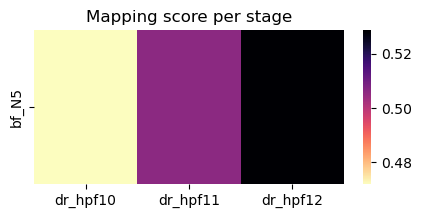

In [8]:
plt.gcf().set_size_inches(5, 2)
plt.title('Mapping score per stage')
sns.heatmap(stages_map,cmap="magma_r")
plt.savefig('figures/hm_stages.pdf',bbox_inches='tight')
plt.savefig('figures/hm_stages.png',dpi=250,bbox_inches='tight')

### Per celltype

Fine annotation

In [9]:
print('mapping scores between fine celltypes')
sankey_plot(MappingTable50_fine, align_thr=0.5, species_order = ['bf','dr'])

mapping scores between fine celltypes


:Sankey   [source,target]   (Value)

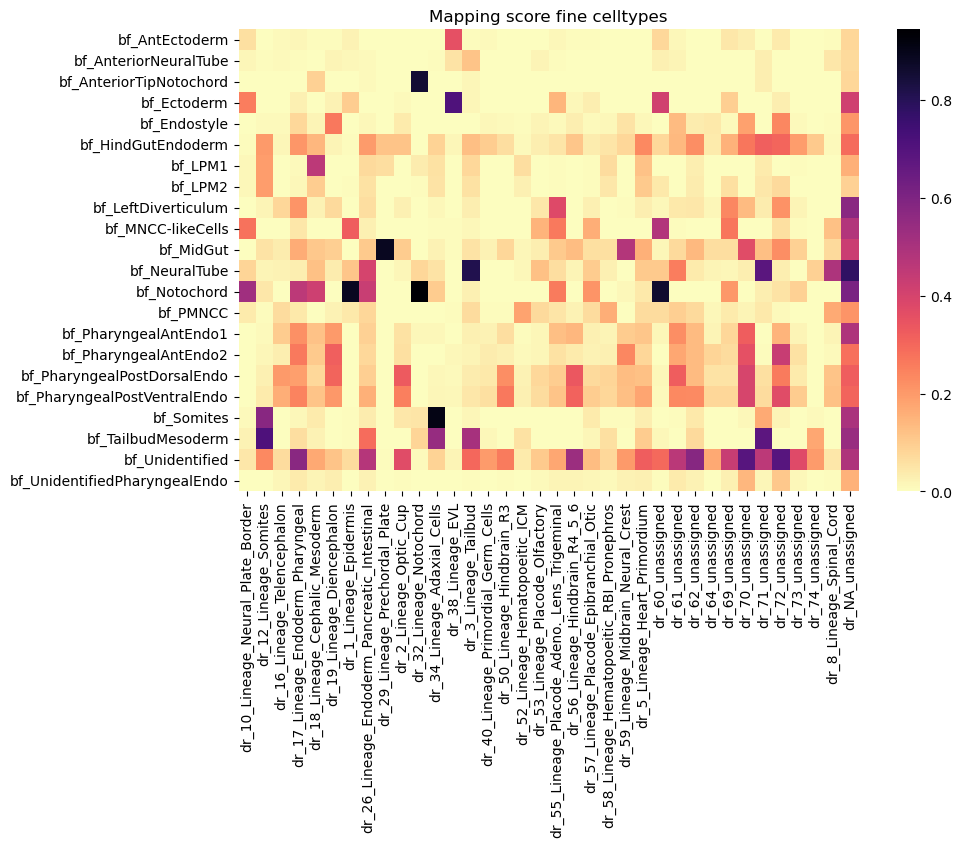

In [12]:
plt.gcf().set_size_inches(10, 6)
plt.title('Mapping score fine celltypes')
sns.heatmap(MappingTable50_fine.filter(regex=("dr_.*")).filter(axis='index',regex=("bf_.*")),cmap="magma_r")#,ax=ax)#[0])
plt.savefig('figures/hm_celltype_fine.pdf',bbox_inches='tight')
plt.savefig('figures/hm_celltype_fine.png',dpi=250,bbox_inches='tight')

Coarse annotation

In [ ]:
print('mapping scores between coarse celltypes')

sankey_plot(MappingTable50_coarse, align_thr=0.8, species_order = ['bf','dr'],node_sort=True)

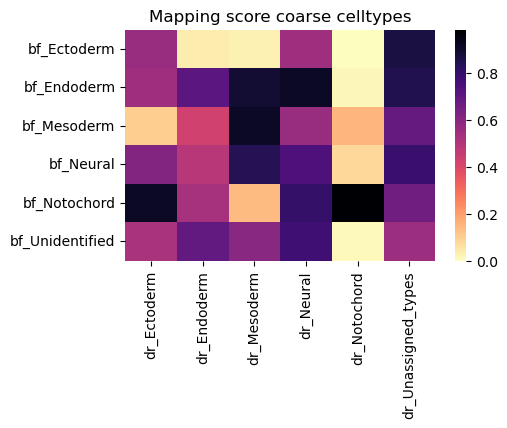

In [13]:
plt.gcf().set_size_inches(5, 3)
plt.title('Mapping score coarse celltypes')
sns.heatmap(MappingTable50_coarse.filter(regex=("dr_.*")).filter(axis='index',regex=("bf_.*")),cmap="magma_r")
plt.savefig('figures/hm_celltype_coarse.pdf',bbox_inches='tight')
plt.savefig('figures/hm_celltype_coarse.png',dpi=250,bbox_inches='tight')

### Per celltype and stage

In [ ]:
print('mapping scores between coarse celltypes by stage')
sankey_plot(MappingTable50_coarse_stage, align_thr=0.5, species_order = ['bf','dr'],node_sort=True)

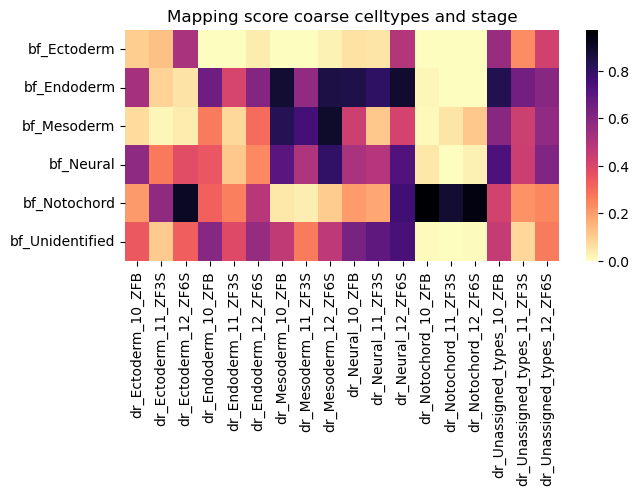

In [19]:
plt.gcf().set_size_inches(7, 3)
plt.title('Mapping score coarse celltypes and stage')
sns.heatmap(MappingTable50_coarse_stage.filter(regex=("dr_.*")).filter(axis='index',regex=("bf_.*")),cmap="magma_r")
plt.savefig('figures/hm_celltype_coarse.pdf',bbox_inches='tight')
plt.savefig('figures/hm_celltype_coarse.png',dpi=250,bbox_inches='tight')

## Others

### Export stacked plots

In [ ]:
ncols = 1
nrows = 3
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

#axs[0].set_title('SAMap UMAP amphioxus (red) vs Zebrafish (blue)')

sc.pl.embedding(sm.sams['bf'].adata,
                    basis='X_umap_samap',
                    color='celltype_coarse2',
                    frameon=True,
                ax=axs[1],
                show=False,
                title="Amphioxus N5",
               size=12)

sc.pl.embedding(sm.sams['dr'].adata,
                    basis='X_umap_samap',
                    color='celltype_coarse',
                    frameon=True,
                ax=axs[2],
                show=False,
                title="Zebrafish 10-12 hpf",
               size=12)

sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=True,
                title='Combined by SAMap',
                size=12,
                ax=axs[0],
                palette={'Zebrafish':('#1b9e77',0.8),'Amphioxus':('#d95f02',0.8)},
               show=False)

fig.savefig('figures/comparison.pdf',bbox_inches='tight')
fig.savefig('figures/comparison.png',bbox_inches='tight',dpi=300)

In [ ]:
ncols = 1
nrows = 3
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)


sc.pl.embedding(sm.sams['bf'].adata,
                    basis='X_umap_samap',
                    color='celltype_fine',
                    groups=['PrechordalPlate','Notochord','MNCC-likeCells','PMNCC'],
                    frameon=True,
                size=12,
                   title='Amphioxus N5',ax=axs[1], show=False)
#sm.scatter(COLORS={'dr':'#10b9f1','bf':'#f14810'},axes=axs[1],ss={'bf':5,'dr':5},alpha=0.5)


sc.pl.embedding(sm.sams['dr'].adata,
                    basis='X_umap_samap',
                    color='segment_celltype',
                    groups=['29_Lineage_Prechordal_Plate',
                            '32_Lineage_Notochord',
                            '59_Lineage_Midbrain_Neural_Crest',
                            '59_Lineage_Placode_Olfactory',
                            '61_unassigned',
                           '70_unassigned'],
                    frameon=True,
                size=12,
               title='Zebrafish 10-12 hpf', ax=axs[2],show=False)

sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=True,
                title='Combined by SAMap',
                ax=axs[0],
                palette={'Zebrafish':('#1b9e77',0.8),'Amphioxus':('#d95f02',0.8)},
                size=12,
               show=False)

fig.savefig('figures/comparison_celltype_selection.pdf',bbox_inches='tight')
fig.savefig('figures/comparison_celltype_selection.png',bbox_inches='tight',dpi=300)

### Export sankey plots

In [ ]:
spf=sankey_plot(MappingTable50_fine, align_thr=0.8, species_order = ['bf','dr'])
export_svg2(spf,filename='figures/sankey_fine.svg')

spf=sankey_plot(MappingTable50_fine, align_thr=0.1, species_order = ['bf','dr'])
export_svg2(spf,filename='figures/sankey_fine01.svg')

spf=sankey_plot(MappingTable50_fine, align_thr=0.2, species_order = ['bf','dr'])
export_svg2(spf,filename='figures/sankey_fine02.svg')

spc=sankey_plot(MappingTable50_coarse, align_thr=0.5, species_order = ['bf','dr'],node_sort=True)
export_svg2(spc,filename='figures/sankey_coarse.svg')

sps=sankey_plot(MappingTable, align_thr=0.15, species_order = ['bf','dr'],node_sort=True)
export_svg2(sps,filename='figures/sankey_stage.svg')

spss=sankey_plot(MappingTable50_coarse_stage, align_thr=0.5, species_order = ['bf','dr'],node_sort=True)
export_svg2(spss,filename='figures/sankey_stage_coarse.svg')